In [3]:
import cv2
import numpy as np
from face_alignment import FaceAlignment as Facial_features
from face_alignment import LandmarksType 
import os
import pickle
import glob
import matplotlib.pyplot as plt
import imageio
from skimage import io
import skimage
import copy
import math
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
image_path = "../images/"

input_img_path = os.path.join(image_path,"face2.png")
ref_img_path = os.path.join(image_path,"style5.png")
style_mask_path = os.path.join(image_path,"mask_style5.png")

input_img=cv2.imread(input_img_path)
input_img=cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)

ref_img = cv2.imread(ref_img_path)
ref_img=cv2.cvtColor(ref_img,cv2.COLOR_BGR2RGB)
style_img = ref_img

style_mask = cv2.imread(style_mask_path)
style_mask=cv2.cvtColor(style_mask,cv2.COLOR_BGR2GRAY)
# plt.imshow(ref_img)
# plt.show()

In [30]:
def grabcut_mask(img):
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(img.shape[:2], dtype="uint8")
#     contours, hierarchy = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    bounding_boxes= [(0,0,img.shape[1],img.shape[0])]
    rect = (bounding_boxes[0][0]+1,bounding_boxes[0][1]+1,bounding_boxes[0][0]+bounding_boxes[0][2]-80,bounding_boxes[0][1]+bounding_boxes[0][3]-80)
    fgModel = np.zeros((1, 65), dtype="float")
    bgModel = np.zeros((1, 65), dtype="float")
    start = time.time()
    (mask, bgModel, fgModel) = cv2.grabCut(img, mask, rect, bgModel,fgModel, iterCount=20, mode=cv2.GC_INIT_WITH_RECT)
    outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),0, 1)
    outputMask = (outputMask * 255).astype("uint8")
    return outputMask
def get_keypoints(img):
    feature_detector = Facial_features(LandmarksType._2D, device='cpu', flip_input=False)
    kp = feature_detector.get_landmarks(img)[0]
    return kp

def dense_correspondence(style_img, input_img, kp1, kp2):
        h, w, c = style_img.shape
        trans_coord = np.meshgrid(range(h), range(w), indexing='ij')
        yy, xx = trans_coord[0].astype(np.float64), trans_coord[1].astype(np.float64)  # might need to switch

        cumm_x = xx * 0.
        cumm_y = yy * 0.
        cumm_w = xx * 0.
        for i in range(len(kp1) - 1):
            if i in {16, 21, 26, 30, 35, 47}:
                continue
            elif i is 41:
                j = 36
            elif i is 47:
                j = 42
            elif i is 59:
                j = 48
            elif i is 67:
                j = 60
            else:
                j = i + 1
            # Computes u, v
            x1 = kp1[j, 0] - kp1[i, 0]
            y1 = kp1[j, 1] - kp1[i, 1]
            norm1 = (x1 ** 2 + y1 ** 2) ** 0.5

            u = ((xx - kp1[i, 0]) * x1 + (yy - kp1[i, 1]) * y1) / norm1 ** 2
            v = ((xx - kp1[i, 0]) * -y1 + (yy - kp1[i, 1]) * x1) / norm1

            # Computes x', y'
            x2 = kp2[j, 0] - kp2[i, 0]
            y2 = kp2[j, 1] - kp2[i, 1]
            norm2 = (x2 ** 2 + y2 ** 2) ** 0.5

            x = kp2[i, 0] + u * (kp2[j, 0] - kp2[i, 0]) + (v * -y2) / norm2  # X'(x)
            y = kp2[i, 1] + u * (kp2[j, 1] - kp2[i, 1]) + (v * x2) / norm2  # X'(y)

            # Computes weights
            d1 = ((xx - kp1[j, 0]) ** 2 + (yy - kp1[j, 1]) ** 2) ** 0.5
            d2 = ((xx - kp1[i, 0]) ** 2 + (yy - kp1[i, 1]) ** 2) ** 0.5
            d = np.abs(v)
            d[u > 1] = d1[u > 1]
            d[u < 0] = d2[u < 0]
            W = (norm1 ** 1 / (10 + d)) ** 1

            cumm_w += W
            cumm_x += W * x
            cumm_y += W * y
        x_m = cumm_x / cumm_w
        y_m = cumm_y / cumm_w
        vx = xx - x_m
        vy = yy - y_m
        vx[x_m < 1] = 0
        vx[x_m > w] = 0
        vy[y_m < 1] = 0
        vy[y_m > h] = 0
        vx = (vx + xx).astype(int)
        vy = (vy + yy).astype(int)
        vx[vx >= w] = w - 1
        vy[vy >= h] = h - 1
        warp = np.ones(style_img.shape)
        warp[yy.astype(int), xx.astype(int)] = style_img[vy, vx]
        return warp, vx, vy

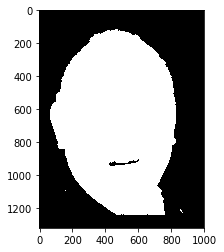

In [13]:
input_mask = grabcut_mask(input_img)
plt.imshow(input_mask,'gray')
plt.show()

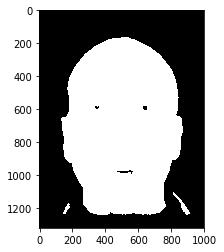

In [14]:
style_mask2 = grabcut_mask(style_img)
plt.imshow(style_mask2,'gray')
plt.show()

In [15]:
input_kp = get_keypoints(input_img)
style_kp = get_keypoints(style_img)

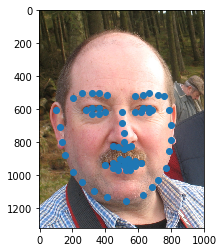

In [16]:
plt.imshow(input_img)
plt.scatter(input_kp[:,0], input_kp[:,1],)

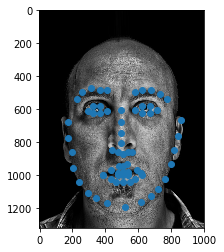

In [17]:
plt.imshow(style_img)
plt.scatter(style_kp[:,0], style_kp[:,1])

In [29]:
warp,vx,vy = dense_correspondence(style_img,input_img,style_kp,input_kp)

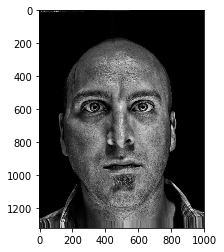

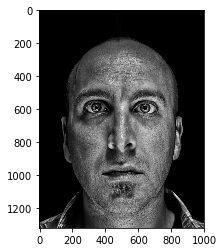

In [27]:
plt.imshow(warp/255)
plt.show()
plt.imshow(style_img)

In [32]:
def local_matching():
    #-to do energy funcs and local shifting -#
    return